In [279]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import wfdb
import ast
import json
import os
import tqdm

# Objective
Given a 12 lead ECG system, classify the infarction stadium level.
* Noise may or may not be present in the signal

# Strategy
* First, train a neural network (NN) to identify the four types of noise ['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems']
* Next, train a neural network to identify the infarction stadium (IS) using the 12 lead signal information with an additional layer than indicates what type of noise is in the signal for each lead.
* In Production, each lead is passed through the noise detection NN to detect noise. That information is then passed to the IS neural network with the signals to make a classification.

In [280]:
root_directory_path = '/home/complukter/Desktop/PTBXL-data'
sig_database = pd.read_csv(os.path.join(root_directory_path, 'ptbxl_database.csv'), index_col='ecg_id')
sig_database.columns


Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

Remove the stuff we don't need

In [281]:
sig_database = sig_database.drop(
    ['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'validated_by_human','extra_beats', 'pacemaker'],
    axis=1
)
print(sig_database.columns)

Index(['report', 'scp_codes', 'heart_axis', 'infarction_stadium1',
       'infarction_stadium2', 'baseline_drift', 'static_noise', 'burst_noise',
       'electrodes_problems', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')


# Looking at one Signal
* We will use the 100 hz sample

[[-0.119 -0.055  0.064 ... -0.026 -0.039 -0.079]
 [-0.116 -0.051  0.065 ... -0.031 -0.034 -0.074]
 [-0.12  -0.044  0.076 ... -0.028 -0.029 -0.069]
 ...
 [ 0.069  0.    -0.069 ...  0.024 -0.041 -0.058]
 [ 0.086  0.004 -0.081 ...  0.242 -0.046 -0.098]
 [ 0.022 -0.031 -0.054 ...  0.143 -0.035 -0.12 ]] {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'comments': []}
[-0.119, -0.055, 0.064, 0.086, -0.091, 0.004, -0.069, -0.031, 0.0, -0.026, -0.039, -0.079, -0.116, -0.051, 0.065, 0.083, -0.09, 0.006, -0.064, -0.036, -0.003, -0.031, -0.034, -0.074, -0.12, -0.044, 0.076, 0.082, -0.098, 0.016, -0.058, -0.034, -0.01, -0.028, -0.029, -0.069, -0.117, -0.038, 0.08, 0.077, -0.098, 0.021, -0.05, -0.03, -0.015, -0.023, -0.022, -0.064, -0.103, -0.031, 0.072, 0.066, -0.087, 0.021, -0.045, -0.027, -0.02, 

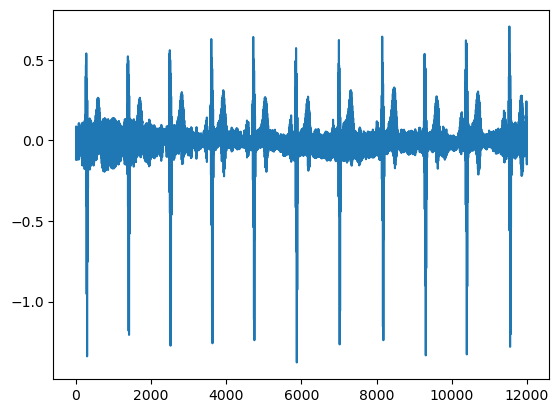

In [282]:
def load_one_sample(path):
    data = wfdb.rdsamp(path)
    signals = np.asmatrix(data[0])
    meta = data[1]
    return signals, meta

one_sample = sig_database.iloc[0]
file_path = one_sample['filename_lr']
signals, meta = load_one_sample(os.path.join(root_directory_path, file_path))
print(signals, meta)
signal = signals.flatten().tolist()[0]
print(signal)
plt.plot(range(len(signal)), signal)
plt.show()

# Infarction Stadium Labels
Infarction Stadium details how damaged the heart tissue is.
* I used the methodology described in this paper to distill the labels: https://arxiv.org/pdf/2306.15681

In [283]:
infarction_labels = sig_database['infarction_stadium1']
print(set(infarction_labels))

{'Stadium I', 'Stadium II-III', 'unknown', nan, 'Stadium II', 'Stadium III', 'Stadium I-II'}


In [284]:
def fix_infarction_label(label):
    if pd.isna(label) or label == "unknown":
        return "None"
    if label == "Stadium I-II":
        return "Stadium I"
    if label == "Stadium II-III":
        return "Stadium II"
    return label
    
infarction_labels = infarction_labels.apply(lambda x: fix_infarction_label(x))
print(set(infarction_labels))

{'Stadium I', 'Stadium III', 'None', 'Stadium II'}


In [285]:
sig_database = sig_database.drop(
    ['infarction_stadium1', 'infarction_stadium2'],
    axis=1  # Drop columns
)
sig_database['infarction_labels'] = infarction_labels
sig_database.columns

Index(['report', 'scp_codes', 'heart_axis', 'baseline_drift', 'static_noise',
       'burst_noise', 'electrodes_problems', 'strat_fold', 'filename_lr',
       'filename_hr', 'infarction_labels'],
      dtype='object')

In [286]:
set(sig_database.heart_axis.values.flatten())

{'ALAD', 'ARAD', 'AXL', 'AXR', 'LAD', 'MID', 'RAD', 'SAG', nan}

In [287]:
codes = sig_database[['scp_codes']]
codes.head()

,scp_codes
ecg_id,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"
2,"{'NORM': 80.0, 'SBRAD': 0.0}"
3,"{'NORM': 100.0, 'SR': 0.0}"
4,"{'NORM': 100.0, 'SR': 0.0}"
5,"{'NORM': 100.0, 'SR': 0.0}"


In [288]:
unique_codes = set()
for i in range(len(codes)):
    code_dict = ast.literal_eval(codes.iloc[i]['scp_codes'])
    for key in code_dict.keys():
        unique_codes.add(str(key))
unique_codes = sorted(list(unique_codes))

In [289]:
print(len(unique_codes))

71


# Noise Identification Dataset
The issue with this dataset is that there is lots of noise in the signals. Thankfully, the 4 types of noise have been tagged by the lead. I want to clean up this dataset and create a noise classifier, however, there is a lot of garbage labelings. The goal is to first make a pipeline that can parse the strings and map them to the leads, and for the examples where it's not clear,  look at them individually. Additionally, tag the clean ones as clean.

Assumptions we are making:
- the ';' is replacable with a ',' not a '-'. Meaning it does not represent a range.
- Any other strings other than lead names, 'nan' or 'alles' will be rejected from the dataset
- lead order in the 'lead_table' comes from the signal meta data from one of the signal samples

In [290]:
lead_table = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
noise_information = sig_database[['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems']]
error_message = 'erroneous'
clean_message = 'clean'

In [291]:
def filter_lead_symbols(lead_string):

    # if the string is empty, we want to tag it as clean
    lead_string = str(lead_string).lower()

    if lead_string == 'nan':
        return clean_message
    
    lead_string = lead_string.replace(';', ',')
        
    strings = [ s.strip().replace(' ', '') for s in str(lead_string).split(',') if s.replace(' ', '') != '']
    final_symbols = []
    for s in strings:

        # All values
        if s == 'alles':
            return lead_table
        
        # Dash Present
        elif '-' in s:
            symbol_range = s.split('-')

            # check if the second value is just a number, if so, add a 'v' to the front of it
            if symbol_range[-1].isdigit():
                symbol_range[-1] = 'v' + symbol_range[-1]

            # Check if the range is possible, if not, then it is garbage
            if symbol_range[0] in lead_table and symbol_range[-1] in lead_table:
                start_index, end_index = lead_table.index(symbol_range[0]), lead_table.index(symbol_range[-1])
                symbols = lead_table[start_index: end_index + 1]
                final_symbols.extend(symbols)

            ####### Garbage
            else:
                return error_message
            
        # no dash
        else:
            if s in lead_table:
                final_symbols.append(s)

            ####### Garbage
            else:
                return error_message

    
    return final_symbols if len(final_symbols) else error_message

In [292]:
# Apply the filter to the full data frame
noise_information = noise_information.map(lambda x: filter_lead_symbols(x))
print(len(noise_information))

21799


In [293]:
# Hightlight the rows that were unparsable even after filter
mask = noise_information.map(lambda x: error_message in str(x))
cleaned_noise_information = noise_information[~mask.any(axis=1)]
print(len(cleaned_noise_information))
print(f"Total lost rows: {len(noise_information) - len(cleaned_noise_information)}")


21483
Total lost rows: 316


In [294]:
# Remove rows from the sig_database that are not present in the cleaned_noise information then apply the changes
sig_database = sig_database.loc[cleaned_noise_information.index]
sig_database[['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems']] = cleaned_noise_information[['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems']]
sig_database.reset_index(drop=True, inplace=True)
print(len(sig_database))
print(sig_database.head())

21483
                                   report  \
0  sinusrhythmus periphere niederspannung   
1     sinusbradykardie sonst normales ekg   
2              sinusrhythmus normales ekg   
3              sinusrhythmus normales ekg   
4              sinusrhythmus normales ekg   

                                  scp_codes heart_axis   baseline_drift  \
0  {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}        NaN            clean   
1              {'NORM': 80.0, 'SBRAD': 0.0}        NaN            clean   
2                {'NORM': 100.0, 'SR': 0.0}        NaN            clean   
3                {'NORM': 100.0, 'SR': 0.0}        NaN   [ii, iii, avf]   
4                {'NORM': 100.0, 'SR': 0.0}        NaN  [iii, avr, avf]   

                      static_noise burst_noise electrodes_problems  \
0  [i, ii, iii, avr, avl, avf, v1]       clean               clean   
1                            clean       clean               clean   
2                            clean       clean               c

# At this point...
We have parsed the lead information for the four types of noise present in the signals and have removed the unparsable examples from the dataset. Now we will create a dataset where each example is a signal and the label is 5 element array indicating the presence of the noise, for example:

# Format ['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'clean'] could translate to [0, 1, 1, 0, 0] to indicate 'baseline_drift' and 'static noise'
- If there is any noise whatsoever, the clean flag cannot be set.

The way the signal data is stored is in a (10 sec * sample_rate) length array of length 12 arrays, where each index in the 12 value array refers to a specific lead. We first need to flip the array to be oriented the other way, then create the labels and export the dataset.

In [295]:
def load_and_transform(df):
    file_path = df['filename_lr']
    signals, meta = load_one_sample(os.path.join(root_directory_path, file_path))
    signals = signals.T # transpose to get each individual signal on it's own row
    noise_types = ['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'clean'] # The last column is Clean

    classifications = np.zeros((signals.shape[0], len(noise_types)))    # This will store the classifications data
    for noise_index, type in enumerate(noise_types):
        if type == 'clean':
            break
        # Get the indexes of the signals that contain this type of noise using the lead code
        codes_for_noise_type = df[type]

        # No Leads have noise
        if codes_for_noise_type != 'clean':
            for code in codes_for_noise_type:
                lead_index = lead_table.index(code)
                classifications[lead_index][noise_index] = 1

    # If no noise it present in the column, mark the clean label as true
    for lead_index in range(classifications.shape[0]):
        if np.sum(classifications[lead_index: -1]) == 0.0:
            classifications[lead_index][-1] = 1

    # Export the signal, label matchings
    rows = []
    for lead_index in range(signals.shape[0]):
        rows.append({'signal': signals[lead_index].tolist()[0], 'label' : classifications[lead_index]})

    return rows

sample = sig_database.iloc[7]
for l, i in zip(lead_table, [i for i in range(len(lead_table))]):
    print(i, '\t', l)
print(sample[['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems']])
load_and_transform(sample)

0 	 i
1 	 ii
2 	 iii
3 	 avr
4 	 avl
5 	 avf
6 	 v1
7 	 v2
8 	 v3
9 	 v4
10 	 v5
11 	 v6
baseline_drift                           [ii, avf]
static_noise           [i, ii, iii, avr, avl, avf]
burst_noise                                  clean
electrodes_problems                          clean
Name: 7, dtype: object


[{'signal': [-0.041,
   -0.039,
   -0.018,
   -0.013,
   -0.02,
   -0.01,
   -0.034,
   -0.047,
   -0.019,
   -0.03,
   -0.046,
   -0.028,
   -0.019,
   -0.05,
   -0.037,
   -0.022,
   -0.028,
   -0.02,
   -0.054,
   -0.072,
   -0.069,
   -0.072,
   -0.077,
   -0.073,
   -0.068,
   -0.043,
   -0.014,
   -0.024,
   0.007,
   0.036,
   0.051,
   0.048,
   0.038,
   0.034,
   0.0,
   -0.039,
   -0.065,
   -0.059,
   -0.068,
   -0.07,
   -0.083,
   -0.09,
   -0.1,
   -0.108,
   -0.115,
   0.044,
   0.804,
   1.038,
   0.28,
   -0.081,
   -0.035,
   -0.012,
   -0.009,
   -0.024,
   0.0,
   0.001,
   0.008,
   0.002,
   0.006,
   0.016,
   0.017,
   0.035,
   0.04,
   0.046,
   0.077,
   0.124,
   0.143,
   0.155,
   0.218,
   0.243,
   0.236,
   0.265,
   0.279,
   0.231,
   0.153,
   0.093,
   0.031,
   0.016,
   0.004,
   -0.026,
   -0.008,
   -0.039,
   -0.069,
   -0.048,
   -0.046,
   -0.052,
   -0.057,
   -0.047,
   -0.057,
   -0.076,
   -0.074,
   -0.066,
   -0.057,
   -0.069,
   -0.0

In [296]:
# Apply this transform to the entire dataset, producing a new dataframe, export it to a file
# Initialize an empty list to collect all rows
all_rows = []

# Use tqdm to monitor the progress
for index, row in tqdm.tqdm(sig_database.iterrows(), total=sig_database.shape[0], desc="Processing rows"):
    formatted_data = load_and_transform(row)
    all_rows.extend(formatted_data)

# Create the DataFrame from the list of rows
data_to_export = pd.DataFrame(all_rows)

Processing rows:  51%|█████     | 10998/21483 [01:02<00:59, 174.94it/s] 


KeyboardInterrupt: 

In [ ]:
data_to_export.head

RangeIndex(start=0, stop=1, step=1)